## Importations

In [ ]:
import os
import json
import requests
import exifread
from tqdm import tqdm
from PIL import Image
from collections import Counter
from tqdm import tqdm

import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD
from collections import defaultdict

## Extraction des données

In [11]:
# —— CONFIGURATION ——
API_KEY = "50894965-73b898bf29a8cb937a12aafc9"
QUERY   = "landscape+mountain+lake"  # requête de recherche
COUNT   = 200  # nombre d’images à récupérer

# Répertoires de sortie (à ajuster selon votre arborescence)
SCRIPT_DIR = os.getcwd()  # Utilise le répertoire courant dans un notebook
IMG_DIR    = os.path.abspath(os.path.join(SCRIPT_DIR, "./images"))
MD_DIR     = os.path.abspath(os.path.join(SCRIPT_DIR, "./metadata"))

os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(MD_DIR, exist_ok=True)

# —— FONCTIONS ——
def fetch_pixabay(query, per_page=50, page=1):
    url = "https://pixabay.com/api/"
    params = {
        "key": API_KEY,
        "q": query,
        "image_type": "photo",
        "per_page": per_page,
        "page": page
    }
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    return resp.json().get("hits", [])


def download_image(url, dest_path):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    with open(dest_path, 'wb') as f:
        for chunk in response.iter_content(1024):
            f.write(chunk)


def extract_metadata(img_path):
    metadata = {}
    # Taille et format
    with Image.open(img_path) as img:
        width, height = img.size
        metadata['width'] = width
        metadata['height'] = height
        metadata['format'] = img.format
    # Orientation (paysage / portrait / carré)
    if width > height:
        metadata['orientation_cat'] = 'landscape'
    elif height > width:
        metadata['orientation_cat'] = 'portrait'
    else:
        metadata['orientation_cat'] = 'square'
    # EXIF via exifread
    try:
        with open(img_path, 'rb') as f:
            tags = exifread.process_file(f, details=False)
        metadata['DateTime'] = str(tags.get('EXIF DateTimeOriginal', ''))
        metadata['camera_model'] = str(tags.get('Image Model', ''))
    except Exception:
        metadata['DateTime'] = ''
        metadata['camera_model'] = ''
    return metadata


# —— BOUCLE PRINCIPALE ——
total = 0
page = 1
while total < COUNT:
    hits = fetch_pixabay(QUERY, per_page=50, page=page)
    if not hits:
        print("IL n'y a plus de résultats disponibles.")
        break

    for item in tqdm(hits, desc=f"Page {page}"):
        if total >= COUNT:
            break

        img_url = item.get('largeImageURL')
        img_name = f"{QUERY}_{total:03d}.jpg"
        img_path = os.path.join(IMG_DIR, img_name)

        # Télécharger l'image
        download_image(img_url, img_path)

        # Extraction des métadonnées locales
        local_meta = extract_metadata(img_path)

        # Métadonnées API Pixabay
        api_meta = {
            "user":        item.get("user", ""),
            "tags_api":    item.get("tags", ""),
            "likes":       item.get("likes", 0),
            "views":       item.get("views", 0),
            "downloads":   item.get("downloads", 0)
        }

        # Fusion et sauvegarde JSON
        meta = {**local_meta, **api_meta}
        md_file = os.path.join(MD_DIR, img_name + ".json")
        with open(md_file, 'w', encoding='utf-8') as mf:
            json.dump(meta, mf, indent=2, ensure_ascii=False)

        total += 1
    page += 1

print(f"- {total} images et métadonnées collectées dans '{IMG_DIR}' et '{MD_DIR}'.")

Page 4: 100%|██████████| 50/50 [01:19<00:00,  1.58s/it]

- 200 images et métadonnées collectées dans 'f:\Devs\Windows\DATA\TP05\images' et 'f:\Devs\Windows\DATA\TP05\metadata'.


## Étiquetage et annotation

In [14]:
# —— CONFIGURATION ——
IMG_DIR    = os.path.abspath(os.path.join(os.getcwd(), './images'))
MD_DIR     = os.path.abspath(os.path.join(os.getcwd(), './metadata'))
OUT_ANNOT  = os.path.abspath(os.path.join(os.getcwd(), './annotations'))
N_CLUSTERS = 3   # nombre de couleurs dominantes à extraire
SAMPLE_PIX = 10000  # nombre de pixels à échantillonner
os.makedirs(OUT_ANNOT, exist_ok=True)

# —— FONCTION: extraire couleurs dominantes ——
def get_dominant_colors(image_path, n_clusters=N_CLUSTERS, sample=SAMPLE_PIX):
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        arr = np.array(img)
    # aplatir pixels et échantillon
    pixels = arr.reshape(-1, 3)
    if len(pixels) > sample:
        idx = np.random.choice(len(pixels), sample, replace=False)
        pixels = pixels[idx]
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pixels)
    centers = kmeans.cluster_centers_.astype(int)
    counts = Counter(labels)
    # ordonner par fréquence
    freq = counts.most_common()
    dominant = [tuple(centers[label]) for label, _ in freq]
    return dominant

# —— BOUCLE PRINCIPALE ——
for fn in tqdm(os.listdir(IMG_DIR)):
    if not fn.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    img_path = os.path.join(IMG_DIR, fn)
    # extraire couleurs
    colors = get_dominant_colors(img_path)
    # convertir en hex
    hex_colors = ['#%02x%02x%02x' % c for c in colors]
    # charger métadonnées existantes
    md_path = os.path.join(MD_DIR, fn + '.json')
    if os.path.exists(md_path):
        with open(md_path, 'r', encoding='utf-8') as f:
            meta = json.load(f)
    else:
        meta = {}
    # ajouter annotation
    meta['dominant_colors'] = hex_colors
    # sauvegarder annotation
    out_path = os.path.join(OUT_ANNOT, fn + '.json')
    with open(out_path, 'w', encoding='utf-8') as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)

print(f"- Couleurs dominantes extraites et annotations sauvegardées dans '{OUT_ANNOT}'")

100%|██████████| 200/200 [00:19<00:00, 10.29it/s]

- Couleurs dominantes extraites et annotations sauvegardées dans 'f:\Devs\Windows\DATA\TP05\annotations'


## Analyse de données

In [18]:
def load_and_prepare_data(folder_path):
    """
    Charge tous les fichiers JSON d'un dossier, les nettoie et les retourne 
    sous forme de DataFrame Pandas.
    """
    all_annotations = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            filepath = os.path.join(folder_path, filename)
            with open(filepath, 'r') as f:
                data = json.load(f)
                
                # Ajout d'un ID unique pour chaque image (basé sur le nom de fichier)
                data['image_id'] = os.path.splitext(filename)[0]
                
                # Nettoyage des tags : convertir la chaîne en une liste de tags uniques
                if 'tags_api' in data and data['tags_api']:
                    tags_list = [tag.strip() for tag in data['tags_api'].split(',')]
                    # Utiliser set pour obtenir des tags uniques et reconvertir en liste
                    data['tags'] = list(set(tags_list))
                else:
                    data['tags'] = []
                
                # On peut supprimer l'ancienne colonne de tags si on le souhaite
                data.pop('tags_api', None)
                
                all_annotations.append(data)
                
    return pd.DataFrame(all_annotations)

# Charger les données dans un DataFrame
image_df = load_and_prepare_data("annotations")

print("\nPrévisualisation des données des images chargées et préparées :")
print(image_df.head())


Prévisualisation des données des images chargées et préparées :
   width  height format orientation_cat DateTime camera_model          user  \
0   1280     853   JPEG       landscape                         ReneGossner   
1   1280     736   JPEG       landscape                             TeeFarm   
2   1280     853   JPEG       landscape                              dep377   
3   1280     853   JPEG       landscape                        ChiemSeherin   
4   1280     800   JPEG       landscape                        ChiemSeherin   

   likes   views  downloads              dominant_colors  \
0    387  141581     118230  [#3a4a2d, #9a9784, #dfdfdc]   
1   1006  349768     219507  [#6a787b, #2f352b, #bec9d4]   
2    116    9209       6380  [#08231d, #1d3e33, #557352]   
3    294   63899      53451  [#153531, #cbd2e5, #657fa7]   
4    422  221279     197754  [#363d36, #d0cecd, #68705d]   

                          image_id  \
0  landscape+mountain+lake_000.jpg   
1  landscape+mountain+l

In [19]:
def create_realistic_user_profiles(num_users, image_df):
    """
    Génère une DataFrame de profils utilisateurs avec des attributs réalistes.
    """
    # Obtenir tous les tags uniques disponibles pour les assigner aux utilisateurs
    all_tags = list(image_df.explode('tags')['tags'].unique())
    popular_tags = list(image_df.explode('tags')['tags'].value_counts().head(5).index)
    niche_tags = list(image_df.explode('tags')['tags'].value_counts().tail(5).index)

    user_profiles = []
    for i in range(num_users):
        user_id = f"user_{i}"
        
        # 1. Type d'utilisateur : Plus de consommateurs que de créateurs
        user_type = random.choices(['consumer', 'photographer'], weights=[0.85, 0.15], k=1)[0]
        
        # 2. Niveau d'activité : Combien d'images l'utilisateur est susceptible d'aimer
        activity_level = random.choice(['low', 'medium', 'high'])
        
        # 3. Profil de goût : Est-il mainstream ou recherche-t-il des pépites ?
        taste_profile = random.choice(['mainstream', 'niche', 'diverse'])
        
        # 4. Intérêts (tags préférés avec des poids)
        favorite_tags = {}
        if taste_profile == 'mainstream':
            num_tags = random.randint(2, 4)
            tags = random.sample(popular_tags, min(num_tags, len(popular_tags)))
        elif taste_profile == 'niche':
            num_tags = random.randint(2, 4)
            tags = random.sample(niche_tags, min(num_tags, len(niche_tags)))
        else: # diverse
            num_tags = random.randint(3, 6)
            tags = random.sample(all_tags, min(num_tags, len(all_tags)))
            
        for tag in tags:
            favorite_tags[tag] = round(random.uniform(0.6, 1.0), 2) # Poids de l'intérêt

        user_profiles.append({
            'user_id': user_id,
            'user_type': user_type,
            'activity_level': activity_level,
            'taste_profile': taste_profile,
            'favorite_tags': favorite_tags
        })
        
    return pd.DataFrame(user_profiles)

# Générer les profils
user_profiles_df = create_realistic_user_profiles(num_users=50, image_df=image_df)

print("--- PROFILS UTILISATEURS RÉALISTES ---")
print(user_profiles_df.head())

--- PROFILS UTILISATEURS RÉALISTES ---
  user_id user_type activity_level taste_profile  \
0  user_0  consumer         medium         niche   
1  user_1  consumer         medium         niche   
2  user_2  consumer            low         niche   
3  user_3  consumer         medium    mainstream   
4  user_4  consumer            low    mainstream   

                                       favorite_tags  
0  {'cow': 0.74, 'skyscape': 0.9, 'shoes': 0.96, ...  
1  {'grand teton': 0.61, 'shoes': 0.76, 'scenicla...  
2  {'sceniclake sils': 0.87, 'skyscape': 0.69, 'g...  
3                  {'lake': 0.79, 'landscape': 0.89}  
4  {'mountains': 0.86, 'water': 0.73, 'nature': 0.9}  


In [20]:
def generate_interactions_from_profiles(user_profiles_df, image_df):
    """
    Simule les "likes" en se basant sur la compatibilité entre le profil utilisateur
    et les attributs de l'image.
    """
    # Pour l'influence de la popularité, normalisons les likes
    image_df['popularity_score'] = image_df['likes'] / image_df['likes'].max()
    
    all_interactions = []
    
    # Créer un index sur image_id pour des recherches rapides
    images_indexed = image_df.set_index('image_id')
    
    for _, user in user_profiles_df.iterrows():
        # Déterminer combien d'images l'utilisateur va aimer en fonction de son activité
        if user['activity_level'] == 'high':
            num_likes = random.randint(15, 30)
        elif user['activity_level'] == 'medium':
            num_likes = random.randint(5, 14)
        else: # low
            num_likes = random.randint(1, 4)
        
        # S'assurer de ne pas dépasser le nombre total d'images
        num_likes = min(num_likes, len(image_df))
            
        # Calculer un score de pertinence pour chaque image pour cet utilisateur
        image_scores = pd.Series(0.0, index=images_indexed.index)
        
        # 1. Score basé sur les tags
        for tag, weight in user['favorite_tags'].items():
            has_tag_mask = images_indexed['tags'].apply(lambda x: tag in x)
            image_scores[has_tag_mask] += weight
        
        # 2. Influence du profil de l'utilisateur
        # Les utilisateurs "mainstream" sont plus influencés par la popularité
        if user['taste_profile'] == 'mainstream':
            image_scores += images_indexed['popularity_score'] * 0.5 # Poids de l'influence
        
        # Les "photographes" pourraient préférer les images avec des données EXIF
        if user['user_type'] == 'photographer':
            has_exif_mask = (images_indexed['camera_model'] != '')
            image_scores[has_exif_mask] += 0.7 # Bonus pour les pros
            
        # Sélectionner les N images avec le meilleur score
        liked_images = image_scores.nlargest(num_likes).index
        
        for image_id in liked_images:
            all_interactions.append({
                'user_id': user['user_id'],
                'image_id': image_id,
                'liked': 1
            })
            
    return pd.DataFrame(all_interactions)

# Générer les interactions
user_interactions_df = generate_interactions_from_profiles(user_profiles_df, image_df)

print("\n--- INTERACTIONS UTILISATEUR-IMAGE SIMULÉES ---")
print(user_interactions_df.head())


--- INTERACTIONS UTILISATEUR-IMAGE SIMULÉES ---
  user_id                         image_id  liked
0  user_0  landscape+mountain+lake_064.jpg      1
1  user_0  landscape+mountain+lake_063.jpg      1
2  user_0  landscape+mountain+lake_199.jpg      1
3  user_0  landscape+mountain+lake_000.jpg      1
4  user_0  landscape+mountain+lake_001.jpg      1



--- ANALYSE APPROFONDIE ---


C:\Users\Jephte_Dunia\AppData\Local\Temp\ipykernel_16228\159025801.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=user_profiles_df, x='user_type', palette='magma')
C:\Users\Jephte_Dunia\AppData\Local\Temp\ipykernel_16228\159025801.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=user_profiles_df, x='activity_level', order=['low', 'medium', 'high'], palette='viridis')
C:\Users\Jephte_Dunia\AppData\Local\Temp\ipykernel_16228\159025801.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=user_profiles_df, x='taste_

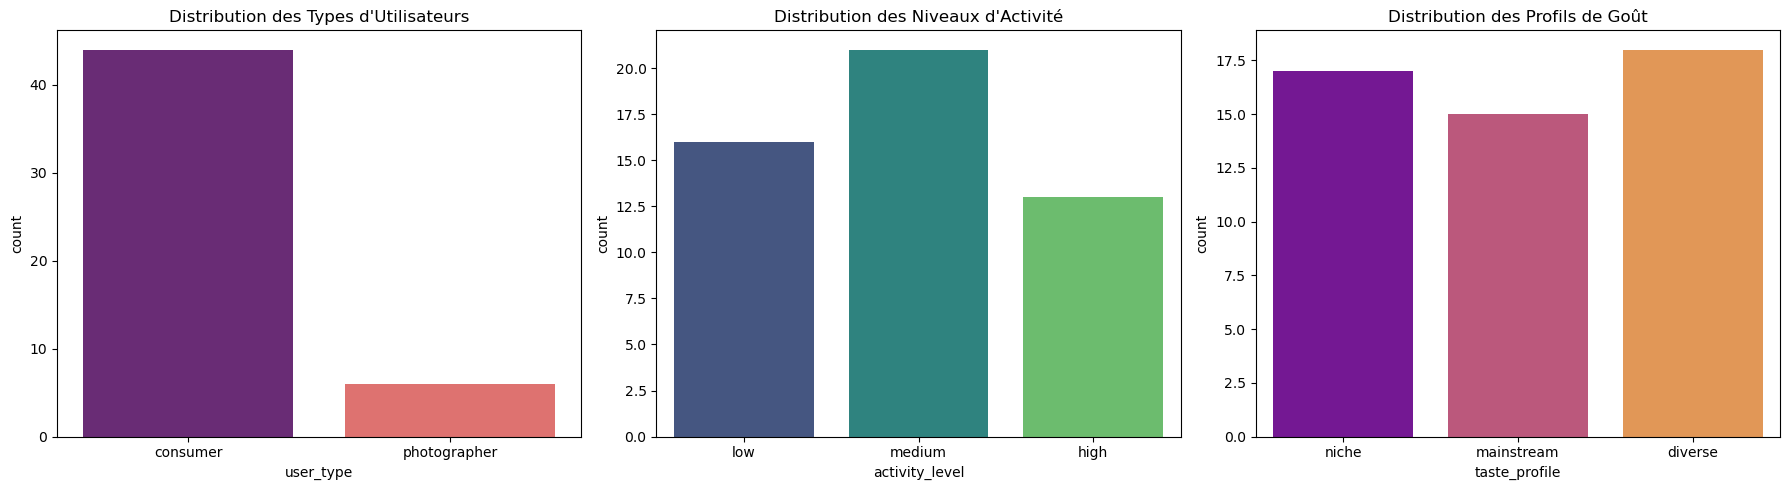

C:\Users\Jephte_Dunia\AppData\Local\Temp\ipykernel_16228\159025801.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=photographer_tags['tags'], order=photographer_tags['tags'].value_counts().index, palette='cividis')


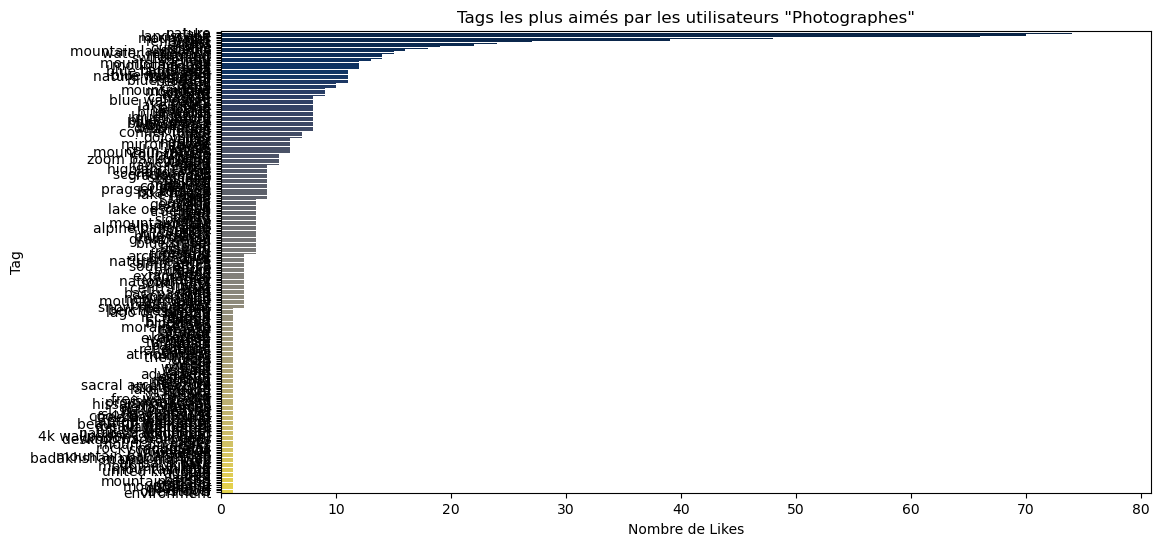

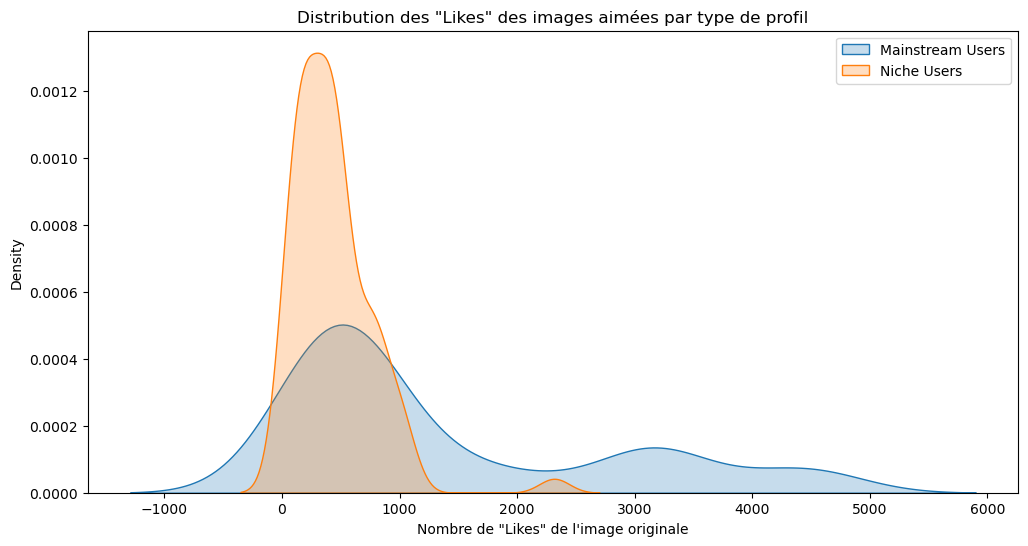

In [23]:
print("\n--- ANALYSE APPROFONDIE ---")

# 1. Analyse des profils utilisateurs générés
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=user_profiles_df, x='user_type', palette='magma')
plt.title('Distribution des Types d\'Utilisateurs')

plt.subplot(1, 3, 2)
sns.countplot(data=user_profiles_df, x='activity_level', order=['low', 'medium', 'high'], palette='viridis')
plt.title('Distribution des Niveaux d\'Activité')

plt.subplot(1, 3, 3)
sns.countplot(data=user_profiles_df, x='taste_profile', palette='plasma')
plt.title('Distribution des Profils de Goût')

plt.tight_layout()
plt.show()

# 2. Analyse croisée : quels sont les tags préférés des "photographes" ?
photographer_profiles = user_profiles_df[user_profiles_df['user_type'] == 'photographer']
photographer_interactions = user_interactions_df[user_interactions_df['user_id'].isin(photographer_profiles['user_id'])]

# Fusionner pour obtenir les détails des images aimées par les photographes
photographer_full_data = pd.merge(photographer_interactions, image_df, on='image_id')

if not photographer_full_data.empty:
    photographer_tags = photographer_full_data.explode('tags')
    
    plt.figure(figsize=(12, 6))
    sns.countplot(y=photographer_tags['tags'], order=photographer_tags['tags'].value_counts().index, palette='cividis')
    plt.title('Tags les plus aimés par les utilisateurs "Photographes"')
    plt.xlabel('Nombre de Likes')
    plt.ylabel('Tag')
    plt.show()
else:
    print("Aucune interaction de photographe n'a été générée (cela peut arriver avec peu de données).")


# 3. Analyse croisée : les utilisateurs "mainstream" aiment-ils les images populaires ?
mainstream_profiles = user_profiles_df[user_profiles_df['taste_profile'] == 'mainstream']
mainstream_interactions = user_interactions_df[user_interactions_df['user_id'].isin(mainstream_profiles['user_id'])]
mainstream_full_data = pd.merge(mainstream_interactions, image_df, on='image_id')

niche_profiles = user_profiles_df[user_profiles_df['taste_profile'] == 'niche']
niche_interactions = user_interactions_df[user_interactions_df['user_id'].isin(niche_profiles['user_id'])]
niche_full_data = pd.merge(niche_interactions, image_df, on='image_id')

plt.figure(figsize=(12, 6))
if not mainstream_full_data.empty:
    sns.kdeplot(mainstream_full_data['likes'], label='Mainstream Users', fill=True)
if not niche_full_data.empty:
    sns.kdeplot(niche_full_data['likes'], label='Niche Users', fill=True)
plt.title('Distribution des "Likes" des images aimées par type de profil')
plt.xlabel('Nombre de "Likes" de l\'image originale')
plt.legend()
plt.show()

## Recommandation

In [ ]:
# --- Préparation des données pour le Content-Based ---
# TF-IDF a besoin d'une chaîne de caractères, pas d'une liste.
# Nous joignons les tags de chaque image en une seule chaîne.
image_df['tags_str'] = image_df['tags'].apply(lambda tags: ' '.join(tags))

# Créer la matrice TF-IDF
tfidf = TfidfVectorizer(stop_words=None) # On peut ajouter des 'stop words' si besoin
tfidf_matrix = tfidf.fit_transform(image_df['tags_str'])

# Calculer la matrice de similarité cosinus entre toutes les images
# Le résultat est une matrice où cosine_sim[i][j] est la similarité entre l'image i et l'image j
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Créer un mapping entre l'image_id et son index dans le DataFrame pour des recherches rapides
image_id_to_index = pd.Series(image_df.index, index=image_df['image_id'])


def recommend_content_based(image_id, num_recommendations=5):
    """
    Recommande des images similaires à une image donnée.
    """
    if image_id not in image_id_to_index:
        return f"Image ID '{image_id}' non trouvée."
        
    # 1. Obtenir l'index de l'image de départ
    idx = image_id_to_index[image_id]
    
    # 2. Obtenir les scores de similarité de cette image avec toutes les autres
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    
    # 3. Trier les images en fonction de leur similarité
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # 4. Obtenir les scores des N images les plus similaires (en ignorant la première, qui est l'image elle-même)
    top_similar_indices = [i[0] for i in sim_scores[1:num_recommendations+1]]
    
    # 5. Retourner les IDs des images recommandées
    recommended_images = image_df['image_id'].iloc[top_similar_indices]
    
    return recommended_images

# --- EXEMPLE D'UTILISATION ---
print("--- MODÈLE 1 : FILTRAGE BASÉ SUR LE CONTENU ---")
# On choisit une image (la première de notre liste) pour trouver des recommandations
source_image = image_df['image_id'][0]
print(f"Image source : {source_image}")
print(f"Tags de l'image source : {image_df[image_df['image_id'] == source_image]['tags'].values[0]}")

recommendations = recommend_content_based(source_image, num_recommendations=2)
print("\nRecommandations :")
print(recommendations)

--- MODÈLE 1 : FILTRAGE BASÉ SUR LE CONTENU ---
Image source : landscape+mountain+lake_000.jpg
Tags de l'image source : ['mountain', 'landscape', 'alps', 'nature', 'turquoise', 'water', 'lake']

Recommandations :
148    landscape+mountain+lake_148.jpg
155    landscape+mountain+lake_155.jpg
Name: image_id, dtype: object


In [ ]:
# --- Préparation des données pour Surprise ---
# La bibliothèque a besoin des données dans un format spécifique
reader = Reader(rating_scale=(0, 1)) # Nos "likes" sont binaires (1 = like)
data = Dataset.load_from_df(user_interactions_df[['user_id', 'image_id', 'liked']], reader)

# Entraîner le modèle SVD sur l'ensemble de nos données d'interactions
trainset = data.build_full_trainset()
model_svd = SVD(n_factors=50, random_state=42) # n_factors est un hyperparamètre à ajuster
model_svd.fit(trainset)

def recommend_collaborative(user_id, num_recommendations=5):
    """
    Recommande des images à un utilisateur en se basant sur les "likes" d'utilisateurs similaires.
    """
    # 1. Trouver les images que l'utilisateur a DÉJÀ aimées
    images_liked_by_user = user_interactions_df[user_interactions_df['user_id'] == user_id]['image_id'].unique()
    
    # 2. Trouver toutes les images uniques que l'utilisateur N'A PAS ENCORE vues/aimées
    all_image_ids = image_df['image_id'].unique()
    images_to_predict = np.setdiff1d(all_image_ids, images_liked_by_user)
    
    # 3. Prédire le score que l'utilisateur donnerait à chacune de ces images
    predictions = []
    for image_id in images_to_predict:
        pred = model_svd.predict(uid=user_id, iid=image_id)
        predictions.append((image_id, pred.est)) # est = estimated score
        
    # 4. Trier les prédictions par score décroissant
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # 5. Retourner les IDs des N meilleures images
    top_n_recs = [pred[0] for pred in predictions[:num_recommendations]]
    
    return top_n_recs

# --- EXEMPLE D'UTILISATION ---
print("\n--- MODÈLE 2 : FILTRAGE COLLABORATIF ---")
# Choisir un utilisateur (par exemple, le premier de notre liste de profils)
target_user = user_profiles_df['user_id'][0]
print(f"Utilisateur cible : {target_user}")
print(f"Profil de goût de l'utilisateur : {user_profiles_df[user_profiles_df['user_id']==target_user]['taste_profile'].values[0]}")
print(f"Tags préférés de l'utilisateur : {user_profiles_df[user_profiles_df['user_id']==target_user]['favorite_tags'].values[0]}")


cf_recommendations = recommend_collaborative(target_user, num_recommendations=3)
print("\nRecommandations collaboratives :")
for rec_id in cf_recommendations:
    tags = image_df.loc[image_df['image_id'] == rec_id, 'tags'].iloc[0]
    print(f"- Image ID: {rec_id}, Tags: {tags}")


--- MODÈLE 2 : FILTRAGE COLLABORATIF ---
Utilisateur cible : user_0
Profil de goût de l'utilisateur : niche
Tags préférés de l'utilisateur : {'cow': 0.74, 'skyscape': 0.9, 'shoes': 0.96, 'grand teton': 0.68}

Recommandations collaboratives :
- Image ID: landscape+mountain+lake_006.jpg, Tags: ['hut', 'landscape', 'stones', 'nature', 'mountain lake', 'mystical', 'water', 'fog', 'reflection', 'lake']
- Image ID: landscape+mountain+lake_007.jpg, Tags: ['canadian rockies', 'outdoors', 'backpacker', 'person', 'cliffs', 'mountain lake', 'backpacking', 'mountaineering', 'summit', 'landscape', 'mountaineer', 'mountain view', 'mountains', 'ridge', 'scenic', 'lake', 'peaks', 'viewpoint', 'man', 'high', 'nature', 'hiker']
- Image ID: landscape+mountain+lake_009.jpg, Tags: ['mountain', 'landscape', 'winter', 'snow', 'nature', 'panorama', 'reservoir', 'lake']


In [26]:
from sklearn.preprocessing import MinMaxScaler

def recommend_hybrid(user_id, source_image_id, num_recommendations=5, alpha=0.5):
    """
    Recommande des images en combinant les approches Content-Based et Collaborative.
    """
    # 1. Obtenir les candidats (toutes les images non aimées par l'utilisateur)
    images_liked_by_user = user_interactions_df[user_interactions_df['user_id'] == user_id]['image_id'].unique()
    candidate_images = np.setdiff1d(image_df['image_id'].unique(), images_liked_by_user)
    
    # 2. Obtenir les scores Content-Based (similaires à source_image_id)
    source_idx = image_id_to_index[source_image_id]
    content_scores = {img_id: cosine_sim_matrix[source_idx][image_id_to_index[img_id]] for img_id in candidate_images}
    
    # 3. Obtenir les scores Collaboratifs
    collaborative_scores = {img_id: model_svd.predict(uid=user_id, iid=img_id).est for img_id in candidate_images}
    
    # 4. Normaliser les scores pour qu'ils soient comparables (échelle 0-1)
    scaler = MinMaxScaler()
    content_scores_norm = scaler.fit_transform(np.array(list(content_scores.values())).reshape(-1, 1)).flatten()
    collaborative_scores_norm = scaler.fit_transform(np.array(list(collaborative_scores.values())).reshape(-1, 1)).flatten()
    
    # 5. Calculer le score hybride
    hybrid_scores = {}
    for i, img_id in enumerate(candidate_images):
        hybrid_score = (alpha * content_scores_norm[i]) + ((1 - alpha) * collaborative_scores_norm[i])
        hybrid_scores[img_id] = hybrid_score
        
    # 6. Trier et retourner les meilleures recommandations
    sorted_hybrid_scores = sorted(hybrid_scores.items(), key=lambda item: item[1], reverse=True)
    
    top_n_recs = [item[0] for item in sorted_hybrid_scores[:num_recommendations]]
    return top_n_recs

# --- EXEMPLE D'UTILISATION ---
print("\n--- MODÈLE 3 : SYSTÈME HYBRIDE ---")
# On utilise le même utilisateur, et on prend une image qu'il a aimée comme référence
last_liked_image = user_interactions_df[user_interactions_df['user_id'] == target_user]['image_id'].iloc[0]

print(f"Utilisateur cible : {target_user}")
print(f"Image de référence pour le contenu : {last_liked_image}")

hybrid_recommendations = recommend_hybrid(target_user, last_liked_image, num_recommendations=3, alpha=0.5)
print("\nRecommandations hybrides (alpha=0.5) :")
for rec_id in hybrid_recommendations:
    tags = image_df.loc[image_df['image_id'] == rec_id, 'tags'].iloc[0]
    print(f"- Image ID: {rec_id}, Tags: {tags}")


--- MODÈLE 3 : SYSTÈME HYBRIDE ---
Utilisateur cible : user_0
Image de référence pour le contenu : landscape+mountain+lake_064.jpg

Recommandations hybrides (alpha=0.5) :
- Image ID: landscape+mountain+lake_115.jpg, Tags: ['mountain', 'landscape', 'alps', 'river', 'mountain range', 'nature', 'alpine', 'panorama', 'switzerland', 'lake']
- Image ID: landscape+mountain+lake_031.jpg, Tags: ['alpsee', 'castle', 'alps', 'mountain range', 'hohenschwangau', 'nature', 'mountains', 'clouds', 'alpine', 'germany', 'europe', 'sky', 'view', 'scenery', 'scenic', 'panorama', 'bavaria', 'lake']
- Image ID: landscape+mountain+lake_129.jpg, Tags: ['mountain', 'landscape', 'wilderness', 'nature', 'outdoors', 'water', 'alpine lake', 'switzerland', 'lake']


--- DÉBUT DE LA VISUALISATION DES DONNÉES DES IMAGES ---


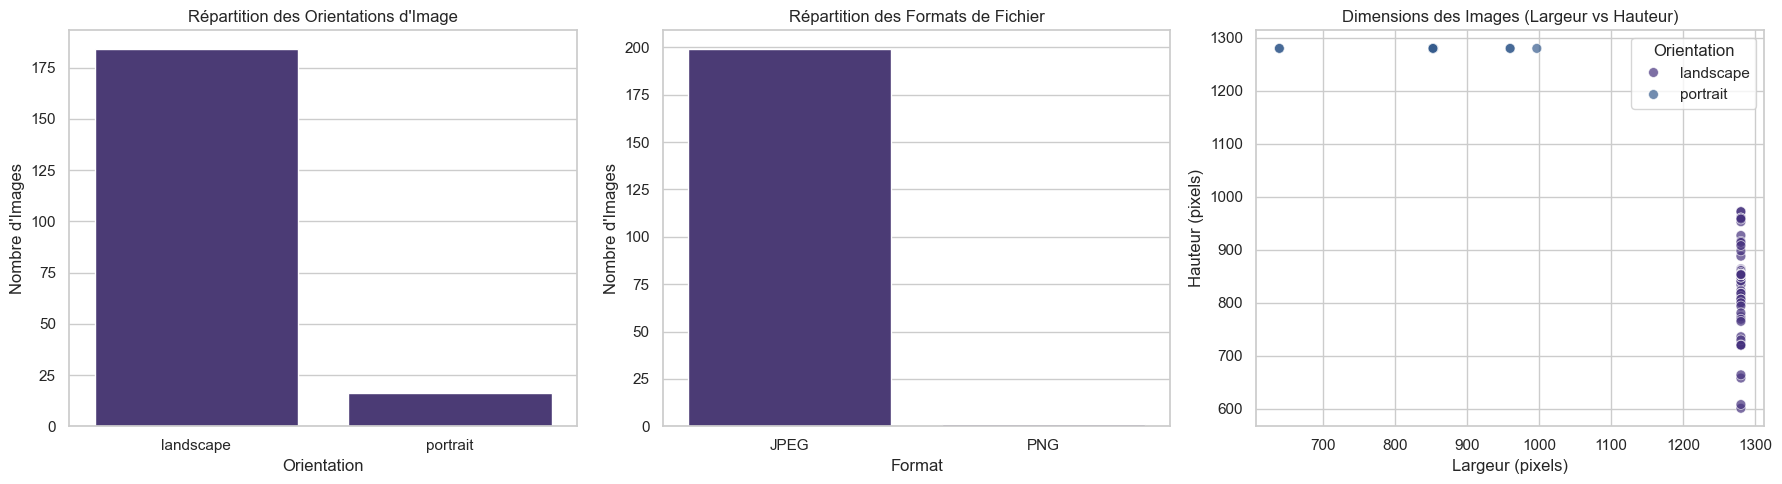

C:\Users\Jephte_Dunia\AppData\Local\Temp\ipykernel_16228\1365065173.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='tags', data=all_tags, order=all_tags['tags'].value_counts().iloc[:15].index, palette='plasma')


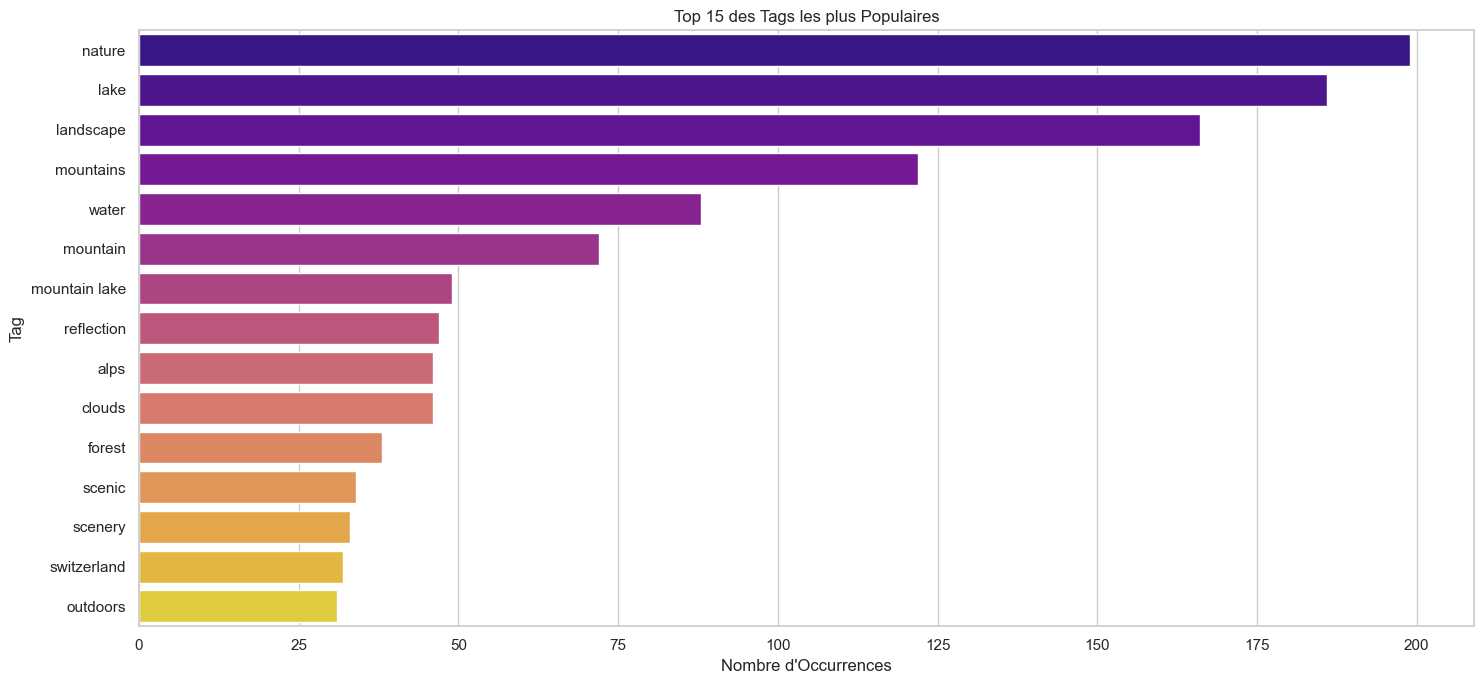

C:\Users\Jephte_Dunia\AppData\Local\Temp\ipykernel_16228\1365065173.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='user', data=photographers, order=photographers['user'].value_counts().iloc[:10].index, palette='magma')


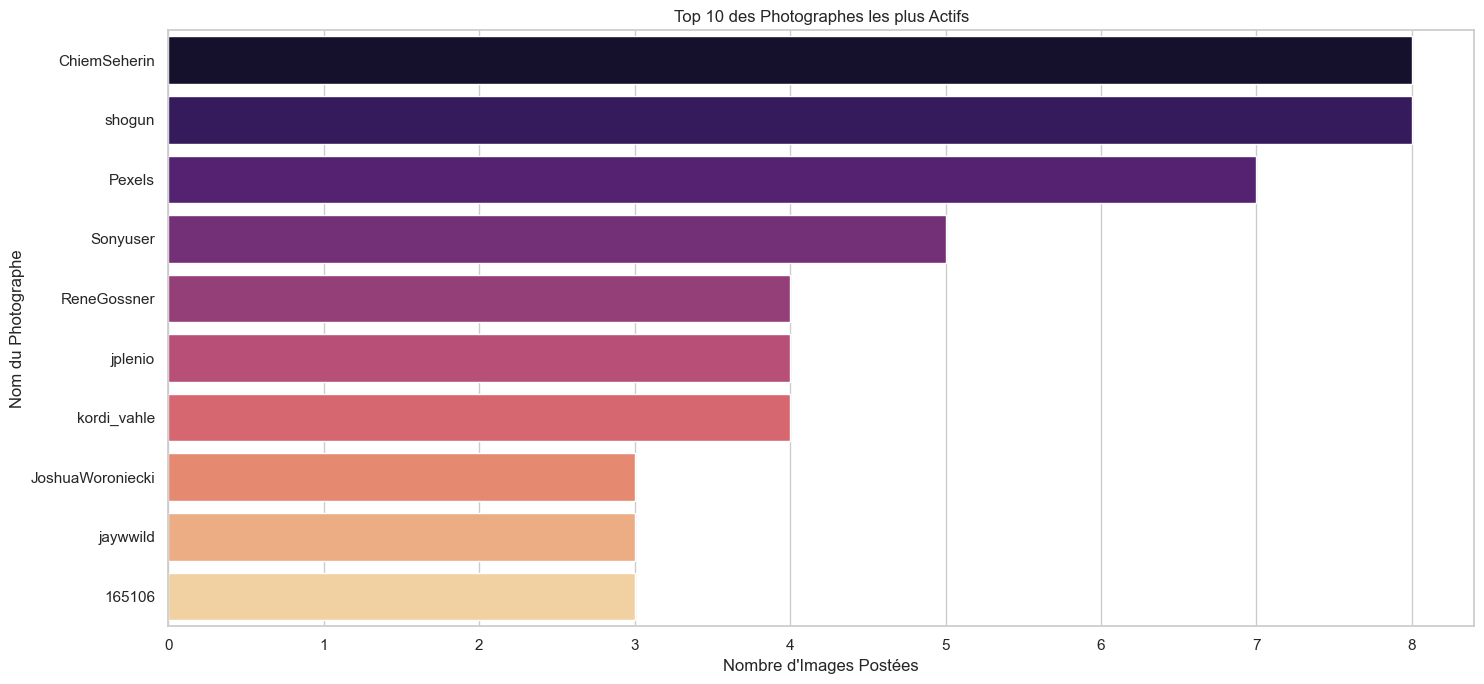

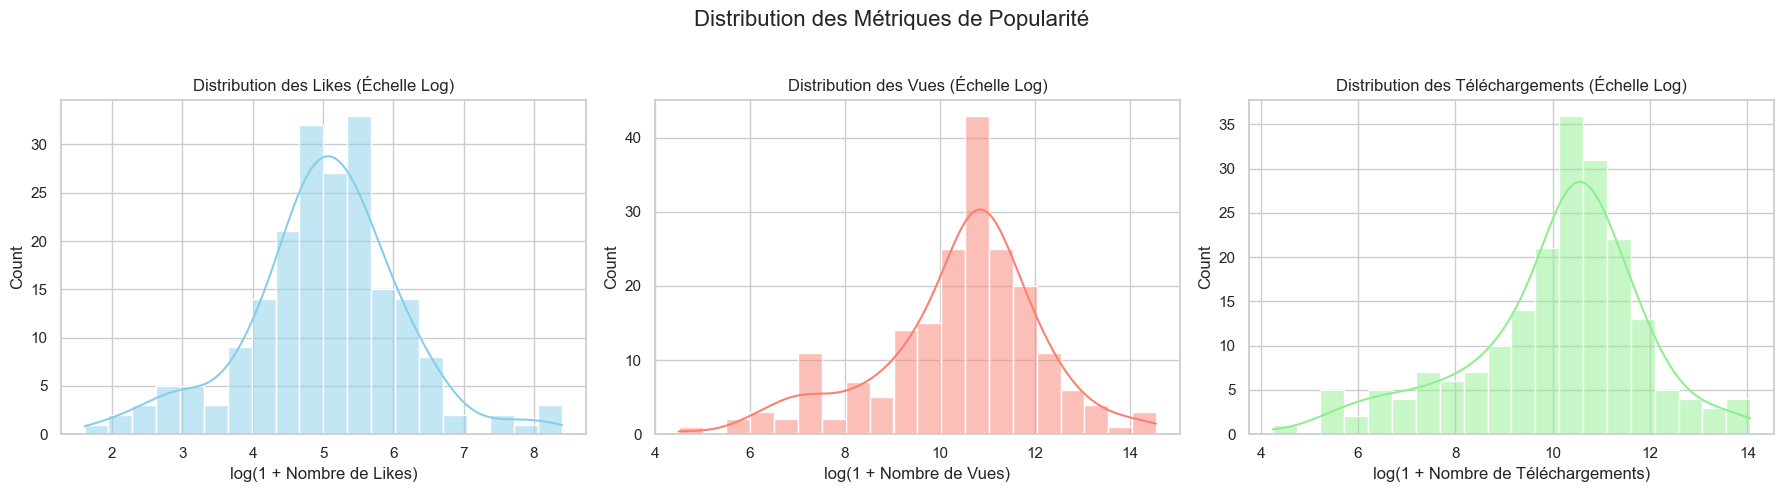

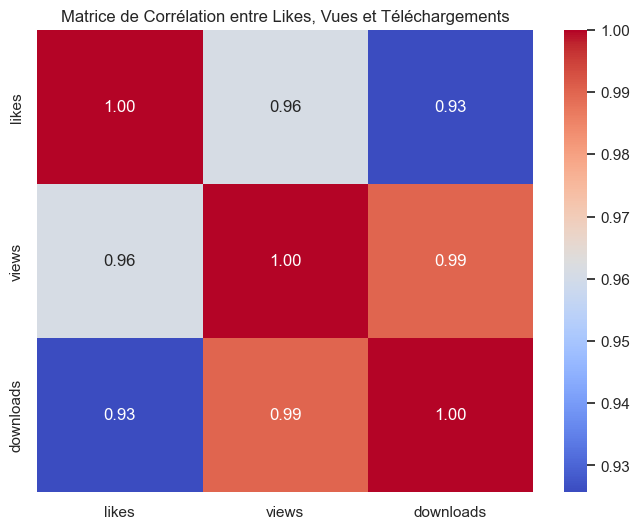

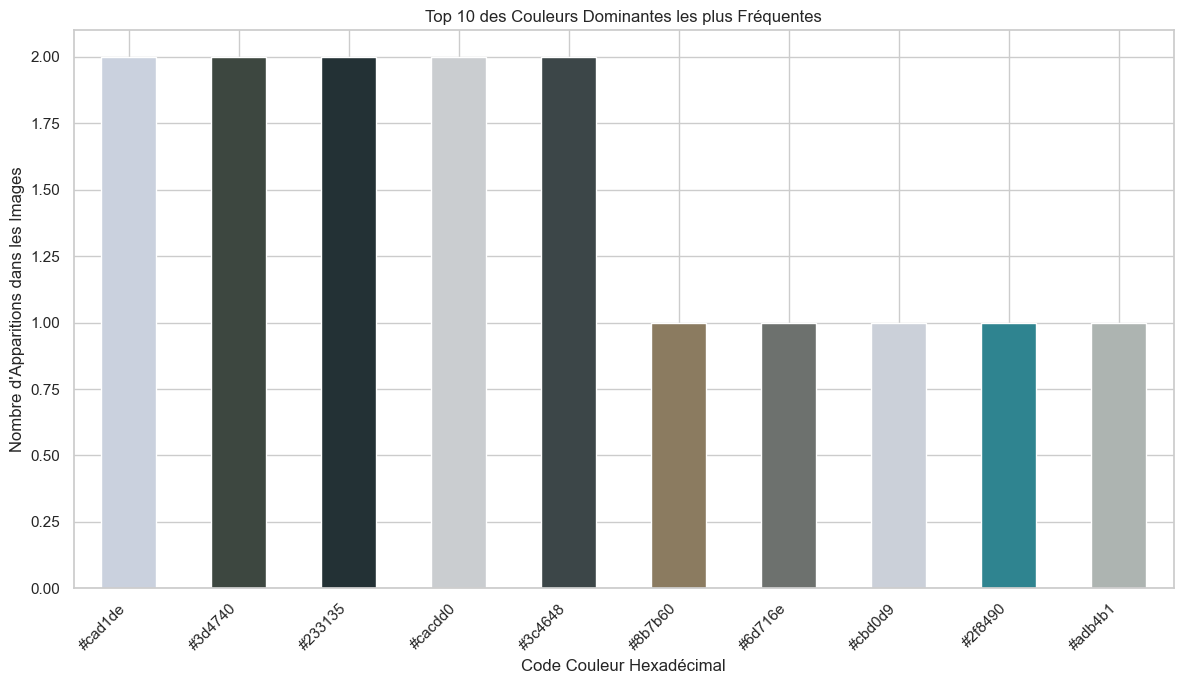


--- FIN DE LA VISUALISATION ---


In [ ]:
print("--- DÉBUT DE LA VISUALISATION DES DONNÉES DES IMAGES ---")

# Configurer le style des graphiques pour un meilleur rendu visuel
sns.set_theme(style="whitegrid", palette="viridis")

# --- 1. Analyse des Caractéristiques Techniques de Base ---

plt.figure(figsize=(18, 5))

# Graphique 1: Distribution des Orientations
plt.subplot(1, 3, 1) # 1 ligne, 3 colonnes, 1er graphique
sns.countplot(x='orientation_cat', data=image_df)
plt.title('Répartition des Orientations d\'Image')
plt.xlabel('Orientation')
plt.ylabel('Nombre d\'Images')

# Graphique 2: Distribution des Formats
plt.subplot(1, 3, 2)
sns.countplot(x='format', data=image_df)
plt.title('Répartition des Formats de Fichier')
plt.xlabel('Format')
plt.ylabel('Nombre d\'Images')

# Graphique 3: Scatter plot des Dimensions (Largeur vs Hauteur)
plt.subplot(1, 3, 3)
sns.scatterplot(x='width', y='height', data=image_df, hue='orientation_cat', alpha=0.7, s=50)
plt.title('Dimensions des Images (Largeur vs Hauteur)')
plt.xlabel('Largeur (pixels)')
plt.ylabel('Hauteur (pixels)')
plt.legend(title='Orientation')

plt.tight_layout() # Ajuste automatiquement les graphiques pour éviter les superpositions
plt.show()

# --- 2. Analyse du Contenu : Tags et Photographes ---

plt.figure(figsize=(15, 7))

# Graphique 4: Les 15 Tags les plus populaires
# On utilise 'explode' pour créer une ligne par tag, puis on compte les occurrences
all_tags = image_df.explode('tags')

# CORRECTION : On réinitialise l'index pour éviter les doublons après 'explode'
all_tags = all_tags.reset_index(drop=True)

# Cette ligne fonctionnera maintenant correctement
sns.countplot(y='tags', data=all_tags, order=all_tags['tags'].value_counts().iloc[:15].index, palette='plasma')
plt.title('Top 15 des Tags les plus Populaires')
plt.xlabel('Nombre d\'Occurrences')
plt.ylabel('Tag')

plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 7))
# Graphique 5: Les 10 Photographes les plus actifs
# Filtrer les utilisateurs vides ou non spécifiés si nécessaire
photographers = image_df[image_df['user'] != ''].copy() # Utiliser .copy() pour éviter un SettingWithCopyWarning
sns.countplot(y='user', data=photographers, order=photographers['user'].value_counts().iloc[:10].index, palette='magma')
plt.title('Top 10 des Photographes les plus Actifs')
plt.xlabel('Nombre d\'Images Postées')
plt.ylabel('Nom du Photographe')

plt.tight_layout()
plt.show()


# --- 3. Analyse des Métriques de Popularité ---

# Graphique 6: Distribution des Likes, Vues et Téléchargements
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
# Utilisation d'une transformation log pour mieux voir la distribution si elle est très écrasée
sns.histplot(np.log1p(image_df['likes']), kde=True, bins=20, color='skyblue')
plt.title('Distribution des Likes (Échelle Log)')
plt.xlabel('log(1 + Nombre de Likes)')

plt.subplot(1, 3, 2)
sns.histplot(np.log1p(image_df['views']), kde=True, bins=20, color='salmon')
plt.title('Distribution des Vues (Échelle Log)')
plt.xlabel('log(1 + Nombre de Vues)')

plt.subplot(1, 3, 3)
sns.histplot(np.log1p(image_df['downloads']), kde=True, bins=20, color='lightgreen')
plt.title('Distribution des Téléchargements (Échelle Log)')
plt.xlabel('log(1 + Nombre de Téléchargements)')

plt.suptitle('Distribution des Métriques de Popularité', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajuster pour le titre principal
plt.show()

# Graphique 7: Matrice de Corrélation entre les métriques
plt.figure(figsize=(8, 6))
correlation_matrix = image_df[['likes', 'views', 'downloads']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Corrélation entre Likes, Vues et Téléchargements')
plt.show()


# --- 4. Analyse des Couleurs Dominantes ---

# Graphique 8: Les 10 couleurs dominantes les plus fréquentes
all_colors = image_df.explode('dominant_colors')

# CORRECTION : On réinitialise l'index ici aussi
all_colors = all_colors.reset_index(drop=True)

top_colors = all_colors['dominant_colors'].value_counts().iloc[:10]

plt.figure(figsize=(12, 7))
# On utilise les codes hexadécimaux comme couleurs pour les barres
top_colors.plot(kind='bar', color=top_colors.index)
plt.title('Top 10 des Couleurs Dominantes les plus Fréquentes')
plt.xlabel('Code Couleur Hexadécimal')
plt.ylabel('Nombre d\'Apparitions dans les Images')
plt.xticks(rotation=45, ha='right') # Améliore la lisibilité des labels de l'axe X
plt.tight_layout()
plt.show()

print("\n--- FIN DE LA VISUALISATION ---")